## Семинар 10: "Генерация текстов"

ФИО: __Федотова Алёна Дмитриевна__

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [2]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

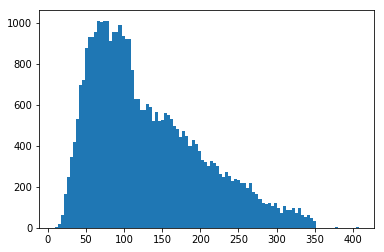

In [3]:
plt.hist(list(map(len, lines)), bins=100);

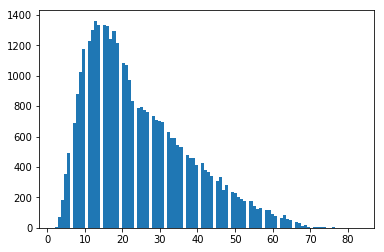

In [4]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [5]:
line = lines[0]

In [6]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [7]:
lines = list(filter(lambda x: len(x.split()) <= 50, lines))

In [8]:
np.random.seed(777)
torch.random.manual_seed(777)

In [9]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [10]:
vocab = Vocabulary(lines)

In [11]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [12]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [13]:
def compose_batch(batch):
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = np.array([len(x[0]) for x in batch])
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [14]:
dataset = Quotes(lines, vocab)

In [15]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

### Часть 2: определение модели

In [16]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [17]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Часть 3: обучение модели

In [18]:
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)

In [19]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [20]:
losses = []

In [17]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

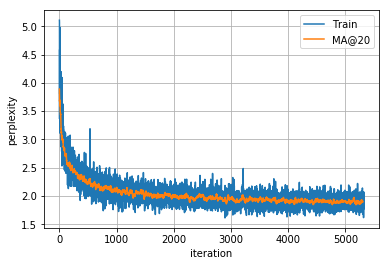

100%|██████████| 536/536 [39:53<00:00,  3.82s/it]


In [22]:
for epoch in range(10):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

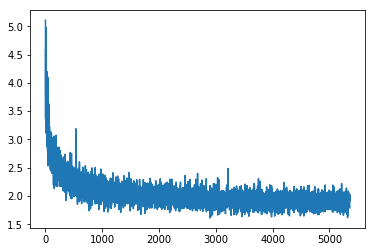

In [23]:
plt.plot(losses)

In [24]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'yeressicta were his ridation.<eos>'

In [25]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"When I moder, I'm not pay than my phot is one of love.<eos>"

In [26]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"I think we don't go almost can be a certains derean, said. I feeling Lorroason and parent defict.<eos>"

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

### 1

In [16]:
class Oracle_LSTM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle_LSTM, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = (Variable(torch.zeros(self.layers, 1, self.hidden_size)),
             Variable(torch.zeros(self.layers, 1, self.hidden_size)))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [26]:
oracle_LSTM = Oracle_LSTM(vocab.size, embedding_size=32, hidden_size=64, layers=4)

In [27]:
optimizer_LSTM = torch.optim.RMSprop(oracle_LSTM.parameters(), lr=0.001, weight_decay=1e-5)

In [28]:
criterion_LSTM = nn.CrossEntropyLoss(reduction='none')

In [29]:
losses_LSTM = []

In [18]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

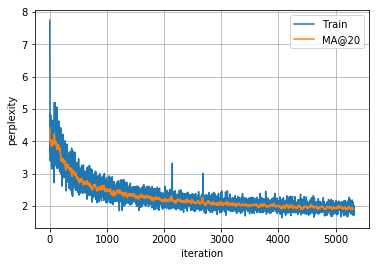


100%|██████████| 536/536 [4:45:42<00:00,  7.52s/it]


In [31]:
for epoch in range(10):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle_LSTM.zero_grad()
        prediction = oracle_LSTM(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion_LSTM(prediction, eos)*mask.float()).mean()
        loss.backward()
        #[x.grad.clamp_(-1, 1) for x in oracle_LSTM.parameters()]
        optimizer_LSTM.step()
        losses_LSTM.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses_LSTM, label='Train')
            plt.plot(moving_average(losses_LSTM), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [32]:
oracle_LSTM.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"I learn to trouds, in this hup's lich grairth of quite ideas, perfects let my first action. The don'"

In [33]:
oracle_LSTM.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'Domid in frashing is an but I want to be stup when we having to we really liy to have in study, anse'

In [34]:
oracle_LSTM.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"No age an better they aragable, you know we dy stronly a from Shets do go the kind old a women's bei"

### 2

In [18]:
dataset = Quotes(lines, vocab)

indices = np.arange(len(dataset))
np.random.shuffle(indices)
split = int(len(dataset) * 0.67)
train_indices, val_indices = indices[:split], indices[split:]
train = list(np.array(dataset)[train_indices])
test = list(np.array(dataset)[val_indices])

train_loader = DataLoader(train, shuffle=True, batch_size=64, collate_fn=compose_batch)
test_loader = DataLoader(test, shuffle=True, batch_size=64, collate_fn=compose_batch)

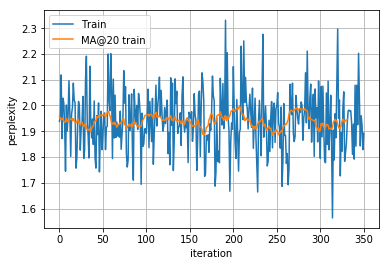

100%|██████████| 177/177 [04:43<00:00,  1.54s/it]


In [19]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(reduction='none')
losses_train = []
losses_test = []
LOSSES_train = []
LOSSES_test = []
alllosses_train = []
alllosses_test = []

for epoch in range(10):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(train_loader, total=len(train_loader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos) * mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses_train.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses_train, label='Train')
            plt.plot(moving_average(losses_train), label='MA@20 train')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()
        
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(test_loader, total=len(test_loader))):
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos) * mask.float()).mean()
        losses_test.append(np.exp(loss.item()))
        
    LOSSES_train.append(np.mean(losses_train))
    LOSSES_test.append(np.mean(losses_test))
    
    alllosses_train += losses_train
    alllosses_test += losses_test
    
    losses_train = []
    losses_test = []
    
# !!! Здесь график не за всё время обучения, а только за последнюю эпоху. На него можно не смотреть.

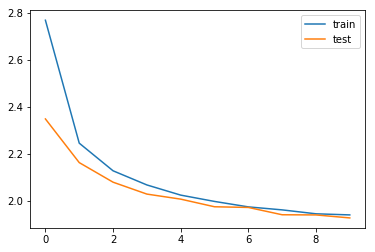

In [20]:
plt.plot(LOSSES_train, label='train')
plt.plot(LOSSES_test, label='test')
plt.legend()
plt.show()

In [21]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'No what you just a speters of bost monters on my with bring, it just just love-sifient is a differen'

In [22]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'Everybodies or generally fans live a very being daying to eae, tell of just duts the body who have b'

In [23]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"Countyen'. You can me the Plancin, - I thirges equages of and my an all. so gildrant of recipory, we"

### 3

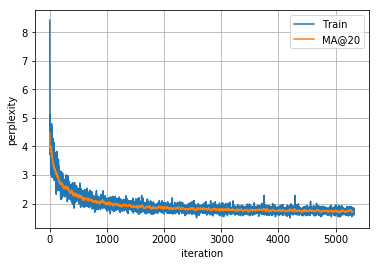


100%|██████████| 536/536 [2:43:27<00:00, 15.27s/it]


In [37]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=128, layers=5)

optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(reduction='none')
losses = []

for epoch in range(10):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [38]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"I don't want to keep future. If your false age - ulless if you does him.<eos>"

In [39]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"The daughter form military busess achievement, reality, and hairing company; I'm justice.<eos>"

In [40]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'The Agever Scodism, I was good reading as obsasta smarter and record in as a lot of pojlection. It w'

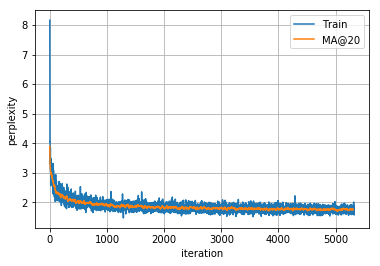

100%|██████████| 536/536 [1:09:27<00:00,  6.71s/it]


In [19]:
oracle = Oracle(vocab.size, embedding_size=64, hidden_size=128, layers=2)

optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(reduction='none')
losses = []

for epoch in range(10):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [20]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"Everything who I can believe in life show what it was a replainers, it's a bookless within there, fe"

In [21]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'A name a community or Eyto, peal is there of parents; faster is not my authority understandire would'

In [22]:
oracle.generate(vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"I don't do that have that that competitative right baseball want.<eos>"

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: